In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# === SETTINGS ===
train_path = r'C:/Users/mamid/OneDrive/Desktop/gradio_example/Disease-Detection-v1/archive/data/train'
validation_path = r'C:/Users/mamid/OneDrive/Desktop/gradio_example/Disease-Detection-v1/archive/data/validation'
folders = ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']


In [ ]:
def extract_color_histogram(image_path, size=(128, 128), bins=32):
    try:
        image = Image.open(image_path).resize(size).convert("RGB")
        hist = []
        for channel in range(3):  # R, G, B
            channel_data = np.array(image)[:, :, channel]
            hist_channel, _ = np.histogram(channel_data, bins=bins, range=(0, 256), density=True)
            hist.extend(hist_channel)
        return hist
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [ ]:
def extract_dataset_features(base_path, folders):
    features, labels = [], []
    for label_index, folder in enumerate(folders):
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder not found - {folder_path}")
            continue
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            if os.path.isfile(img_path):
                hist = extract_color_histogram(img_path)
                if hist:
                    features.append(hist)
                    labels.append(label_index)
    return np.array(features), np.array(labels)


In [1]:

X_train, y_train = extract_dataset_features(train_path, folders)
X_val, y_val = extract_dataset_features(validation_path, folders)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=folders))


                            precision    recall  f1-score   support

               blue_finger       0.56      0.56      0.56         9
Acral_Lentiginous_Melanoma       0.50      0.67      0.57        12
                   pitting       0.40      0.12      0.19        16
           Onychogryphosis       0.42      0.67      0.52        12
                  clubbing       0.42      0.50      0.46        16
              Healthy_Nail       0.88      0.75      0.81        20

                  accuracy                           0.54        85
                 macro avg       0.53      0.54      0.52        85
              weighted avg       0.55      0.54      0.53        85



In [3]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5411764705882353


In [5]:
from sklearn.metrics import log_loss

# Predict probabilities instead of class labels
y_prob = rf.predict_proba(X_val)
loss = log_loss(y_val, y_prob)
print("Log Loss (Cross-Entropy):", loss)


Log Loss (Cross-Entropy): 1.2554630063955314


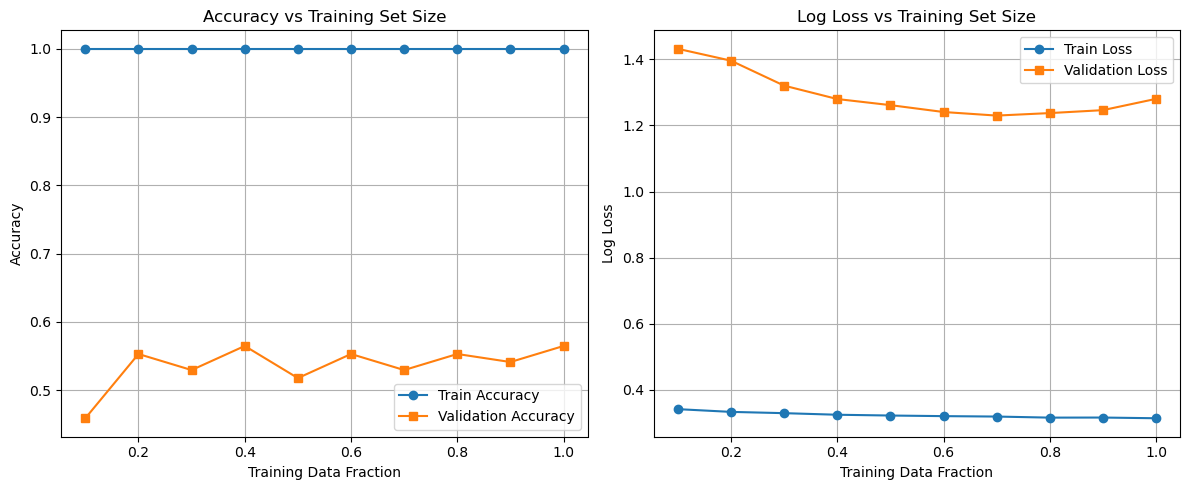

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils import shuffle

# Shuffle the data first
X_train, y_train = shuffle(X_train, y_train, random_state=42)

steps = 10
train_sizes = np.linspace(0.1, 1.0, steps)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for frac in train_sizes:
    split_idx = int(frac * len(X_train))
    X_subset = X_train[:split_idx]
    y_subset = y_train[:split_idx]
    
    rf_partial = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_partial.fit(X_subset, y_subset)
    
    # Training set performance
    y_train_pred = rf_partial.predict(X_subset)
    y_train_prob = rf_partial.predict_proba(X_subset)
    train_accuracies.append(accuracy_score(y_subset, y_train_pred))
    train_losses.append(log_loss(y_subset, y_train_prob))
    
    # Validation set performance
    y_val_pred = rf_partial.predict(X_val)
    y_val_prob = rf_partial.predict_proba(X_val)
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_losses.append(log_loss(y_val, y_val_prob))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", marker='s')
plt.title("Accuracy vs Training Set Size")
plt.xlabel("Training Data Fraction")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_losses, label="Train Loss", marker='o')
plt.plot(train_sizes, val_losses, label="Validation Loss", marker='s')
plt.title("Log Loss vs Training Set Size")
plt.xlabel("Training Data Fraction")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
